In [1]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import numpy as np
import seaborn as sb
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.preprocessing import PolynomialFeatures

In [2]:
dataset = pd.read_csv("loans_full_schema.csv", low_memory=False)

In [3]:
dataset.head()

emp_title  emp_length state homeownership  annual_income  \
0  global config engineer          3.0    NJ      MORTGAGE        90000.0   
1   warehouse office clerk        10.0    HI          RENT        40000.0   
2                 assembly         3.0    WI          RENT        40000.0   
3         customer service         1.0    PA          RENT        30000.0   
4     security supervisor         10.0    CA          RENT        35000.0   

   verified_income  debt_to_income  annual_income_joint  \
0         Verified           18.01                  NaN   
1     Not Verified            5.04                  NaN   
2  Source Verified           21.15                  NaN   
3     Not Verified           10.16                  NaN   
4         Verified           57.96              57000.0   

  verification_income_joint  debt_to_income_joint  ...  sub_grade  \
0                       NaN                   NaN  ...         C3   
1                       NaN                   NaN  ...         C1   
2                       NaN                   NaN  ...         D1   
3                       NaN                   NaN  ...         A3   
4                  Verified                 37.66  ...         C3   

   issue_month  loan_status  initial_listing_status  disbursement_method  \
0     Mar-2018      Current                   whole                 Cash   
1     Feb-2018      Current                   whole                 Cash   
2     Feb-2018      Current              fractional                 Cash   
3     Jan-2018      Current                   whole                 Cash   
4     Mar-2018      Current                   whole                 Cash   

    balance  paid_total  paid_principal  paid_interest  paid_late_fees  
0  27015.86     1999.33          984.14        1015.19             0.0  
1   4651.37      499.12          348.63         150.49             0.0  
2   1824.63      281.80          175.37         106.43             0.0  
3  18853.26     3312.89         2746.74         566.15             0.0  
4  21430.15     2324.65         1569.85         754.80             0.0  

[5 rows x 55 columns]

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
emp_title                           9167 non-null object
emp_length                          9183 non-null float64
state                               10000 non-null object
homeownership                       10000 non-null object
annual_income                       10000 non-null float64
verified_income                     10000 non-null object
debt_to_income                      9976 non-null float64
annual_income_joint                 1495 non-null float64
verification_income_joint           1455 non-null object
debt_to_income_joint                1495 non-null float64
delinq_2y                           10000 non-null int64
months_since_last_delinq            4342 non-null float64
earliest_credit_line                10000 non-null int64
inquiries_last_12m                  10000 non-null int64
total_credit_lines                  10000 non-null int64
open_credit_lines          

In [5]:
### In my visual first screening i will remove the following columns as these are not necessary to build the model
### all these columns are irrelevent for model unless there is any special offer for different emp-title, locations, time of year
### dropping column emp_title , emp_length, state, application_type, loan_status, issue_month, initial_listing_status, disbursement_method

dataset.drop(['emp_title' , 'emp_length', 'state', 'application_type', 'loan_status', 'issue_month', 'initial_listing_status', 'disbursement_method'], axis=1, inplace=True)

## I am adding column annual income (which is primary applicant income) with column annual income joint as it will give us 
## the total income for the household. I will create a new column named total_annual_income and i will drop columns annual_income
### and annual_income_joint

##first we will replace the nan values in the column annual_income_joint with zero
dataset['annual_income_joint'].fillna(0, inplace=True)
dataset['total_annual_income'] = dataset['annual_income'] + dataset['annual_income_joint']

dataset.drop(['annual_income','annual_income_joint'], axis=1, inplace=True)

## As the column verification income joint have only 1495 rows and 90% of them match the verification status with primary holder
## income verification status i am dropping this column 'verification income joint'

dataset.drop(['verification_income_joint'], axis=1, inplace=True)

## information of column debt to income is important but from the data it doesn't look like they are ratios. They are more like
### percentage e..g if debt to income has value 18.01 then it says 18% is debt for the total income

## I am going to replace the NaNs in the column debt_to_income_joint with zero. I would not inpute those values with other values
## as theses are not missing values. 

dataset['debt_to_income_joint'].fillna(0, inplace=True)
dataset['debt_to_income'].fillna(0, inplace=True)

## the column earliest_credit_line has year values. I am going to substract the the loan issue year(2018) with earliest credit line year
## so we would get how much old the earliest credit line was

dataset['earliest_credit_line_age'] = 2018 - dataset['earliest_credit_line']
dataset.drop(['earliest_credit_line'], axis=1, inplace=True)

### I am dropping the column total credit lines as the column open(active) credit line is more important than total credit lines active

dataset.drop(['total_credit_lines'], axis=1, inplace=True)

## I am going to calculate the percentage credit utilized and create a new column percentage_credit_utilized
## then i will drop columns total_credit_limit, total_credit_utilized

dataset['percentage_credit_utilized'] = (dataset['total_credit_utilized'] / dataset['total_credit_limit']) * 100
dataset.drop(['total_credit_utilized','total_credit_limit'], axis=1, inplace=True)

## i will change the months to year for column 'months_since_90d_late' as all the other column unit is in year

dataset['months_since_90d_late'].fillna(0, inplace=True)
dataset['year_since_90dlate'] = (dataset['months_since_90d_late'] / 12).round(2)
dataset.drop(['months_since_90d_late'], axis=1, inplace=True)

## I am counting the zeros in the column num_accounts_120d_past_due,

a =(dataset['num_accounts_120d_past_due'] == 0).sum()
print('the zeros in column num_accounts_120d_past_due are:', a)

b = (dataset['num_accounts_30d_past_due'] == 0).sum()
print('the zeros in column num_accounts_30d_past_due:', b)

## The zeros in above columns are valid zeros. A customer can have 0 or no number of accounts which are default So I will just remove these two columns

dataset.drop(['num_accounts_120d_past_due','num_accounts_30d_past_due'], axis=1, inplace=True)

## i am dropping column num_active_debit_accounts as this column will not affect our model for predicting interest rate
## rather the column total debit limit is what is important for our model as it shows liquid funds available with customer

dataset.drop(['num_active_debit_accounts'], axis=1, inplace=True)

### the column current_accounts_delinq have 9999 zero values hence dropping the column
dataset.drop(['current_accounts_delinq'], axis=1, inplace=True)

## i will calculate the percent number cc carrying balance accounts by dividing number of cc carrying balance and num total
## cc account and multiplying by 100
## as percentage of number of cc carrying balance is important rather than all the three columns for total and active cc num account

dataset['percent_num_cc_carrying_balance'] = (dataset['num_cc_carrying_balance'] / dataset['num_total_cc_accounts']) * 100

## dropping column num_cc_carrying_balance, num_total_cc_accounts, num_open_cc_accounts
dataset.drop(['num_cc_carrying_balance','num_total_cc_accounts','num_open_cc_accounts'], axis=1, inplace=True)

## the columns stating balance, principal or interest paid are the columns we get after loan disbursement information for the particular loan application
## as we are developing a model that will predict the interest rate based on the already loan disbursed data , we will drop these columns

dataset.drop(['balance','paid_total','paid_principal','paid_interest','paid_late_fees'], axis=1, inplace=True)
dataset.drop(['installment','grade','sub_grade'], axis=1, inplace=True)

## i will change the months to year for column 'months_since_last_delinq' as all the other column unit is in year

dataset['months_since_last_delinq'].fillna(0, inplace=True)
dataset['year_since_last_delinq'] = (dataset['months_since_last_delinq'] / 12).round(2)
dataset.drop(['months_since_last_delinq'], axis=1, inplace=True)

## i will change the months to year for column 'months_since_last_credit_inquiry' as all the other column unit is in year

dataset['months_since_last_credit_inquiry'].fillna(0, inplace=True)
dataset['year_since_last_credit_inquiry'] = (dataset['months_since_last_credit_inquiry'] / 12).round(2)
dataset.drop(['months_since_last_credit_inquiry'], axis=1, inplace=True)

dataset['percentage_credit_utilized'].fillna(0, inplace=True)

the zeros in column num_accounts_120d_past_due are: 9682
the zeros in column num_accounts_30d_past_due: 9999


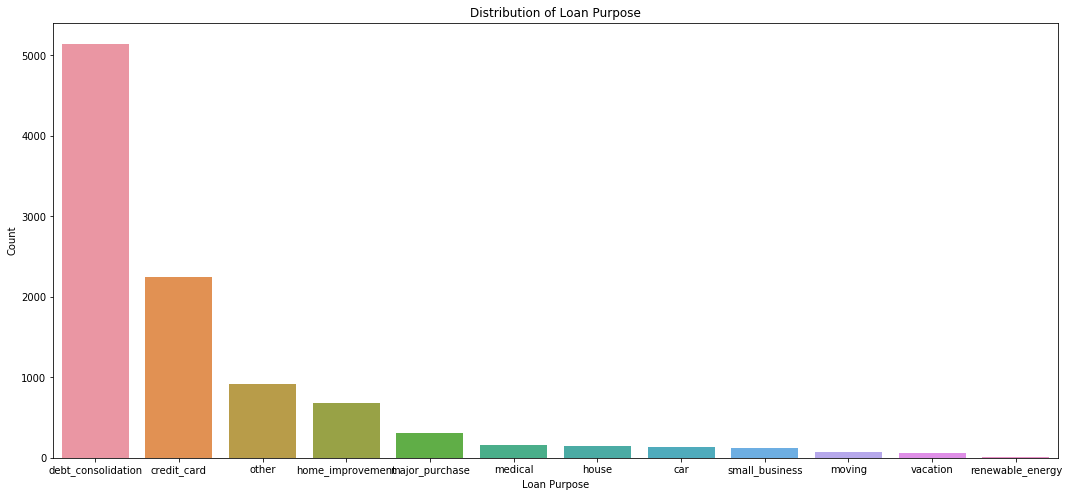

In [6]:
## the below bar plot helps to understand the loan purpose and number of loans approved in each category
## it gave overall idea that debt_consolidation type of loan was taken more than other type of loans
viz_loan_purpose = dataset['loan_purpose'].value_counts().to_frame().reset_index()
viz_loan_purpose.columns = ['Loan Purpose', 'Count']
plt.subplots(figsize=(18,8))
sb.barplot(y='Count', x='Loan Purpose', data=viz_loan_purpose)
plt.ylabel('Count')
plt.title('Distribution of Loan Purpose')
plt.show()

In [7]:
dataset.shape

(10000, 29)

In [8]:
### we will now see our categorical variables
dataset['verified_income'].value_counts()

Source Verified    4116
Not Verified       3594
Verified           2290
Name: verified_income, dtype: int64

In [9]:
## by using label encoder i will convert them to 0,1,2
label_encoder = LabelEncoder()
dataset['verified_income'] = label_encoder.fit_transform(dataset['verified_income'])
dataset['verified_income'].value_counts()

1    4116
0    3594
2    2290
Name: verified_income, dtype: int64

In [10]:
label_encoder = LabelEncoder()
dataset['homeownership'] = label_encoder.fit_transform(dataset['homeownership'])
dataset['homeownership'].value_counts()

0    4789
2    3858
1    1353
Name: homeownership, dtype: int64

In [11]:
label_encoder = LabelEncoder()
dataset['loan_purpose'] = label_encoder.fit_transform(dataset['loan_purpose'])
dataset['loan_purpose'].value_counts()

2     5144
1     2249
8      914
3      680
5      303
6      162
4      151
0      131
10     125
7       69
11      62
9       10
Name: loan_purpose, dtype: int64

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
homeownership                      10000 non-null int32
verified_income                    10000 non-null int32
debt_to_income                     10000 non-null float64
debt_to_income_joint               10000 non-null float64
delinq_2y                          10000 non-null int64
inquiries_last_12m                 10000 non-null int64
open_credit_lines                  10000 non-null int64
num_collections_last_12m           10000 non-null int64
num_historical_failed_to_pay       10000 non-null int64
total_collection_amount_ever       10000 non-null int64
current_installment_accounts       10000 non-null int64
accounts_opened_24m                10000 non-null int64
num_satisfactory_accounts          10000 non-null int64
total_debit_limit                  10000 non-null int64
num_mort_accounts                  10000 non-null int64
account_never_delinq_percent       10000 non-nul

In [13]:
## it a very useful data visualization tool tells us the minimum and maximum values in the dataset, the mean and median values and it also helps to understand the data distribution
dataset.describe()

homeownership  verified_income  debt_to_income  debt_to_income_joint  \
count   10000.000000     10000.000000    10000.000000          10000.000000   
mean        0.906900         0.869600       19.261852              2.986906   
std         0.925266         0.755945       15.016585              7.775200   
min         0.000000         0.000000        0.000000              0.000000   
25%         0.000000         0.000000       10.997500              0.000000   
50%         1.000000         1.000000       17.530000              0.000000   
75%         2.000000         1.000000       24.990000              0.000000   
max         2.000000         2.000000      469.090000             39.980000   

         delinq_2y  inquiries_last_12m  open_credit_lines  \
count  10000.00000         10000.00000        10000.00000   
mean       0.21600             1.95820           11.40440   
std        0.68366             2.38013            5.86828   
min        0.00000             0.00000            0.00000   
25%        0.00000             0.00000            7.00000   
50%        0.00000             1.00000           10.00000   
75%        0.00000             3.00000           14.00000   
max       13.00000            29.00000           51.00000   

       num_collections_last_12m  num_historical_failed_to_pay  \
count              10000.000000                  10000.000000   
mean                   0.013800                      0.167100   
std                    0.126535                      0.687768   
min                    0.000000                      0.000000   
25%                    0.000000                      0.000000   
50%                    0.000000                      0.000000   
75%                    0.000000                      0.000000   
max                    3.000000                     52.000000   

       total_collection_amount_ever  ...   loan_amount          term  \
count                  10000.000000  ...  10000.000000  10000.000000   
mean                     184.334000  ...  16361.922500     43.272000   
std                     2206.389859  ...  10301.956759     11.029877   
min                        0.000000  ...   1000.000000     36.000000   
25%                        0.000000  ...   8000.000000     36.000000   
50%                        0.000000  ...  14500.000000     36.000000   
75%                        0.000000  ...  24000.000000     60.000000   
max                   199308.000000  ...  40000.000000     60.000000   

       interest_rate  total_annual_income  earliest_credit_line_age  \
count   10000.000000         1.000000e+04               10000.00000   
mean       12.427524         9.834538e+04                  16.71000   
std         5.001105         8.381625e+04                   7.79551   
min         5.310000         5.235000e+03                   3.00000   
25%         9.430000         5.000000e+04                  12.00000   
50%        11.980000         7.500000e+04                  15.00000   
75%        15.050000         1.200000e+05                  21.00000   
max        30.940000         2.300000e+06                  55.00000   

       percentage_credit_utilized  year_since_90dlate  \
count                10000.000000        10000.000000   
mean                    40.307697            0.878024   
std                     26.934606            1.831252   
min                      0.000000            0.000000   
25%                     16.900230            0.000000   
50%                     36.016310            0.000000   
75%                     60.729463            0.000000   
max                    183.527954           10.670000   

       percent_num_cc_carrying_balance  year_since_last_delinq  \
count                     10000.000000             10000.00000   
mean                         45.269962                 1.33009   
std                          22.541282                 1.92788   
min                           0.000000                 0.00000   
25%                       

  Correlation matrix plot


<function matplotlib.pyplot.show(*args, **kw)>

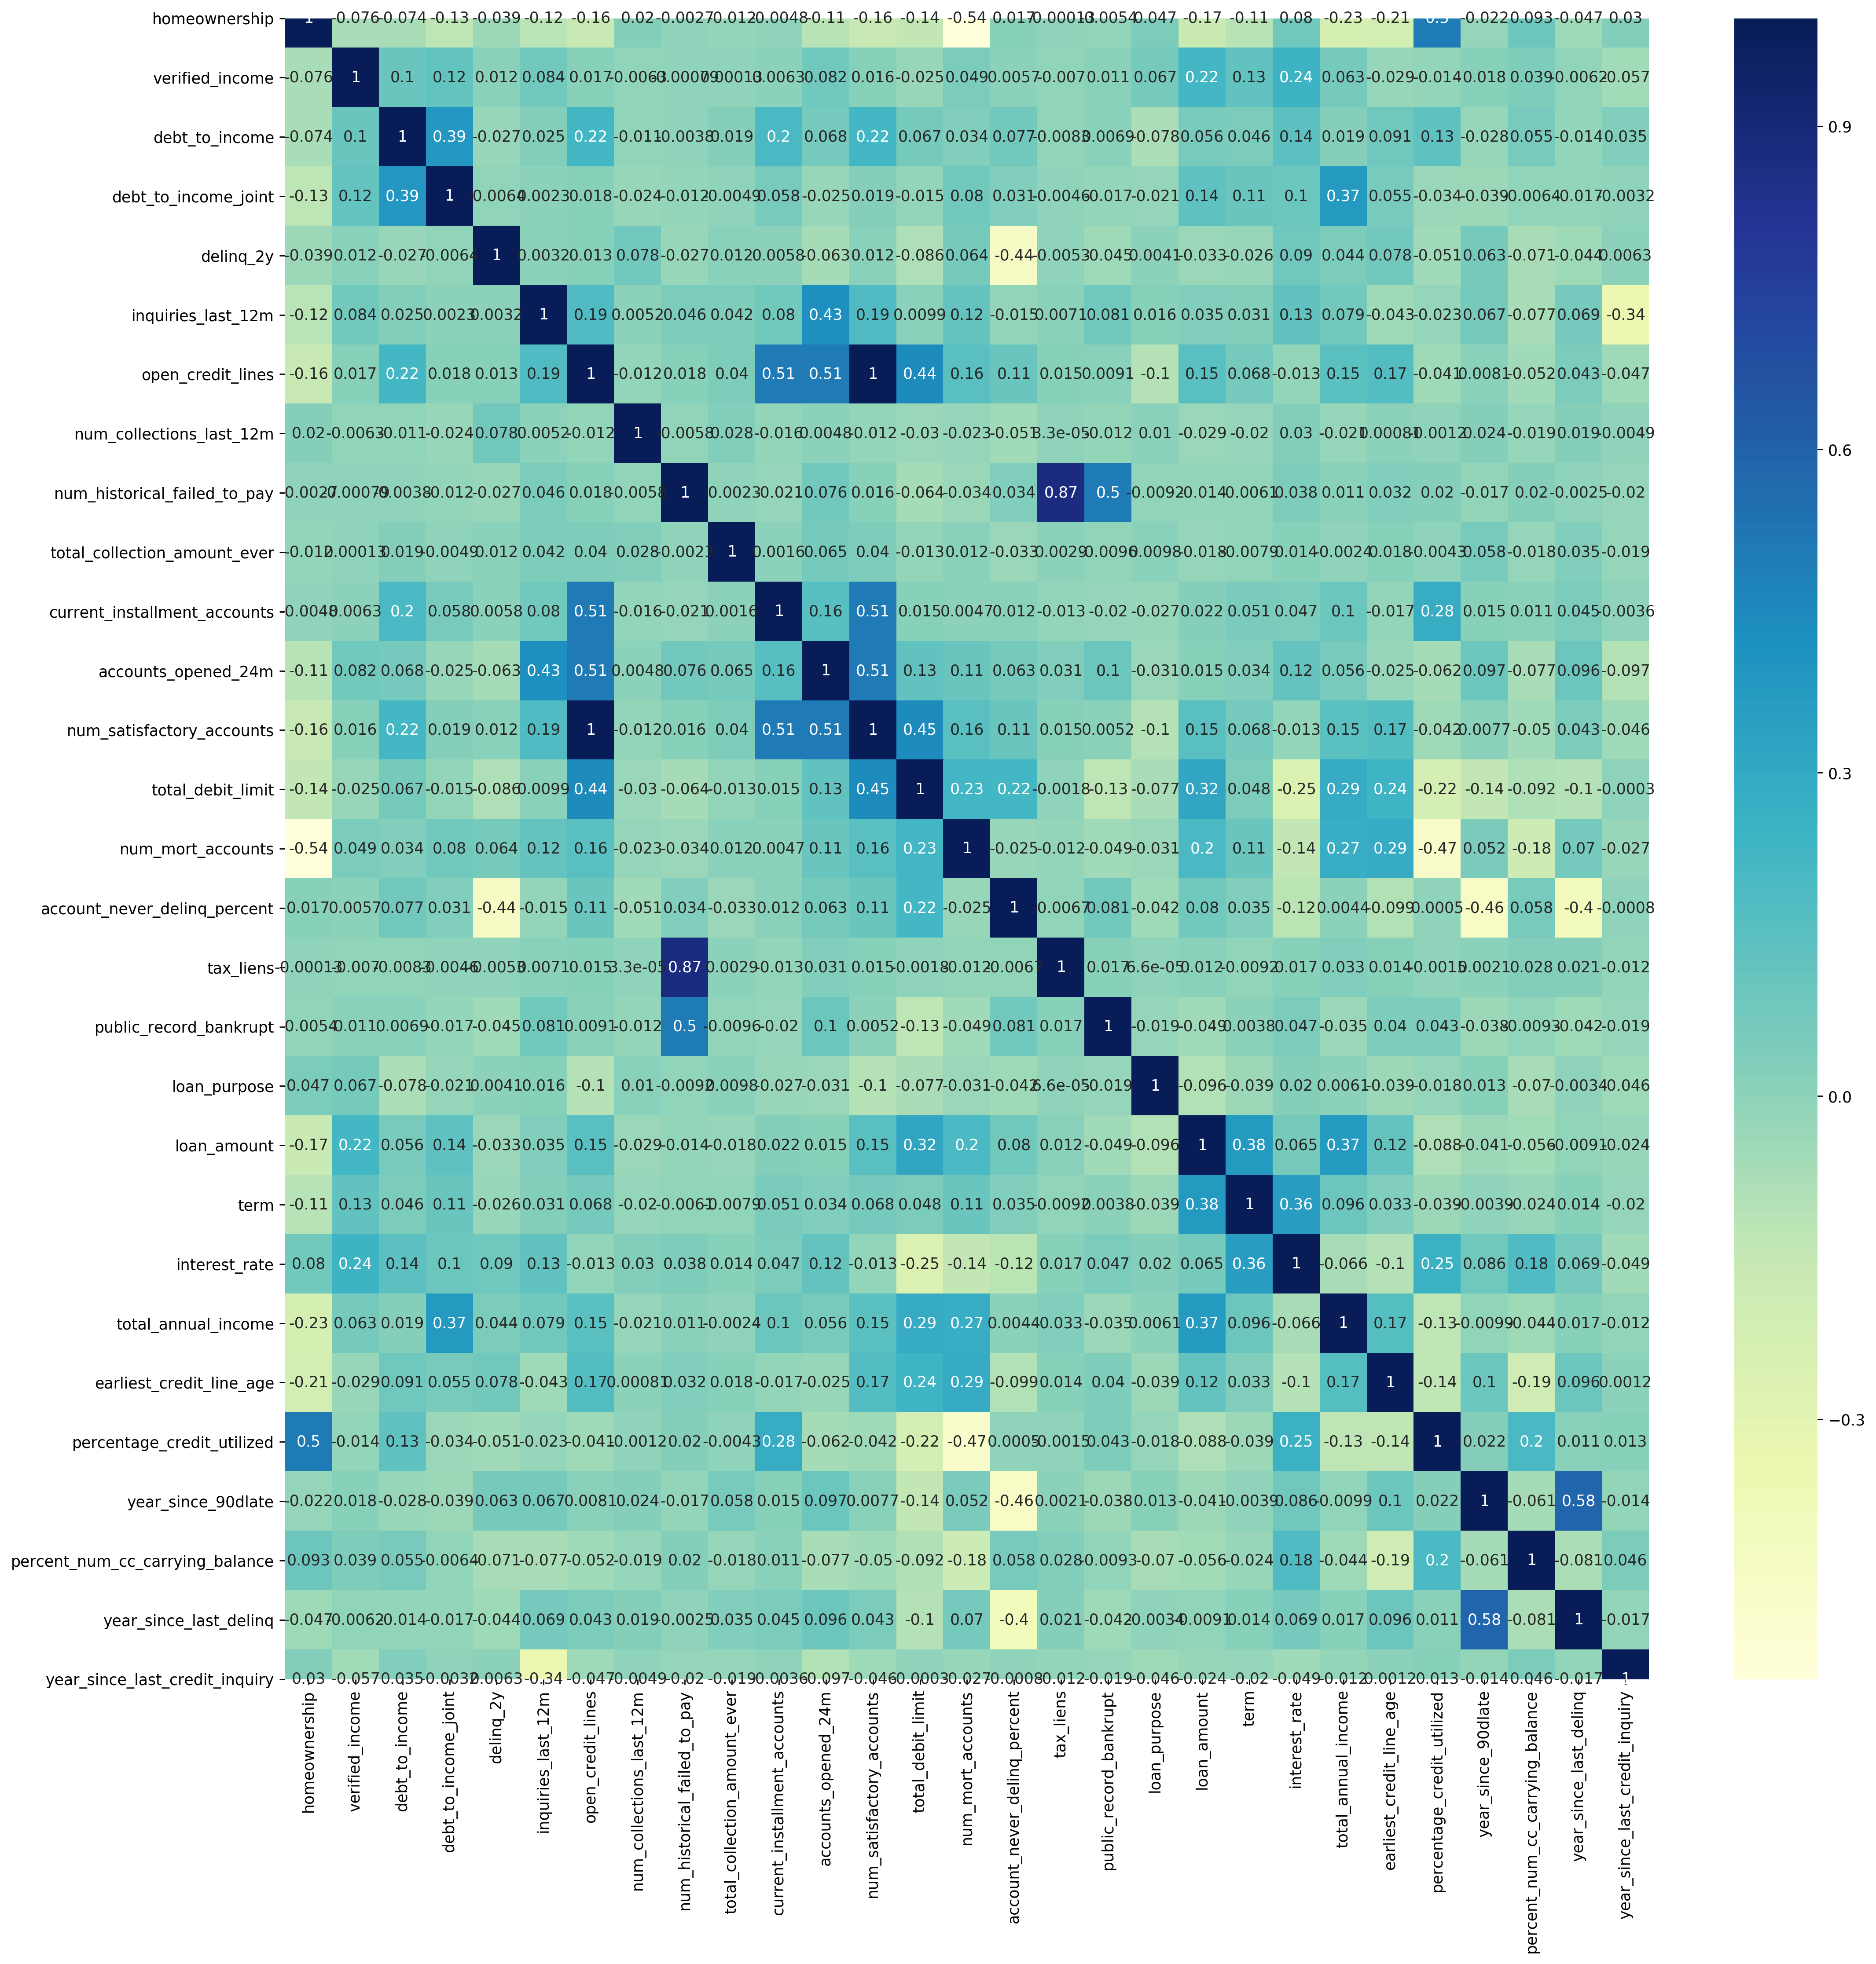

In [17]:
## the correlation matrix plot is very important to visualize the correlation between two variables. correlation coefficient value
## 1 tells us that there positive correlation and -1 negative correlation. if two variables are highly correlated we remove those variables
## to avoid biased predictions.
## from the below correlation plot i  am going to remove the column num_stisfactory_account

print("  Correlation matrix plot")
dataplot = sb.heatmap(dataset.corr(), cmap="YlGnBu", annot=True)
plt.show

In [18]:
## histograms are frequency plots which shows data distribution.

print("  Histogram")
dataset.hist(figsize=(40,40), bins=15)
plt.show()

  Histogram


  Density plot


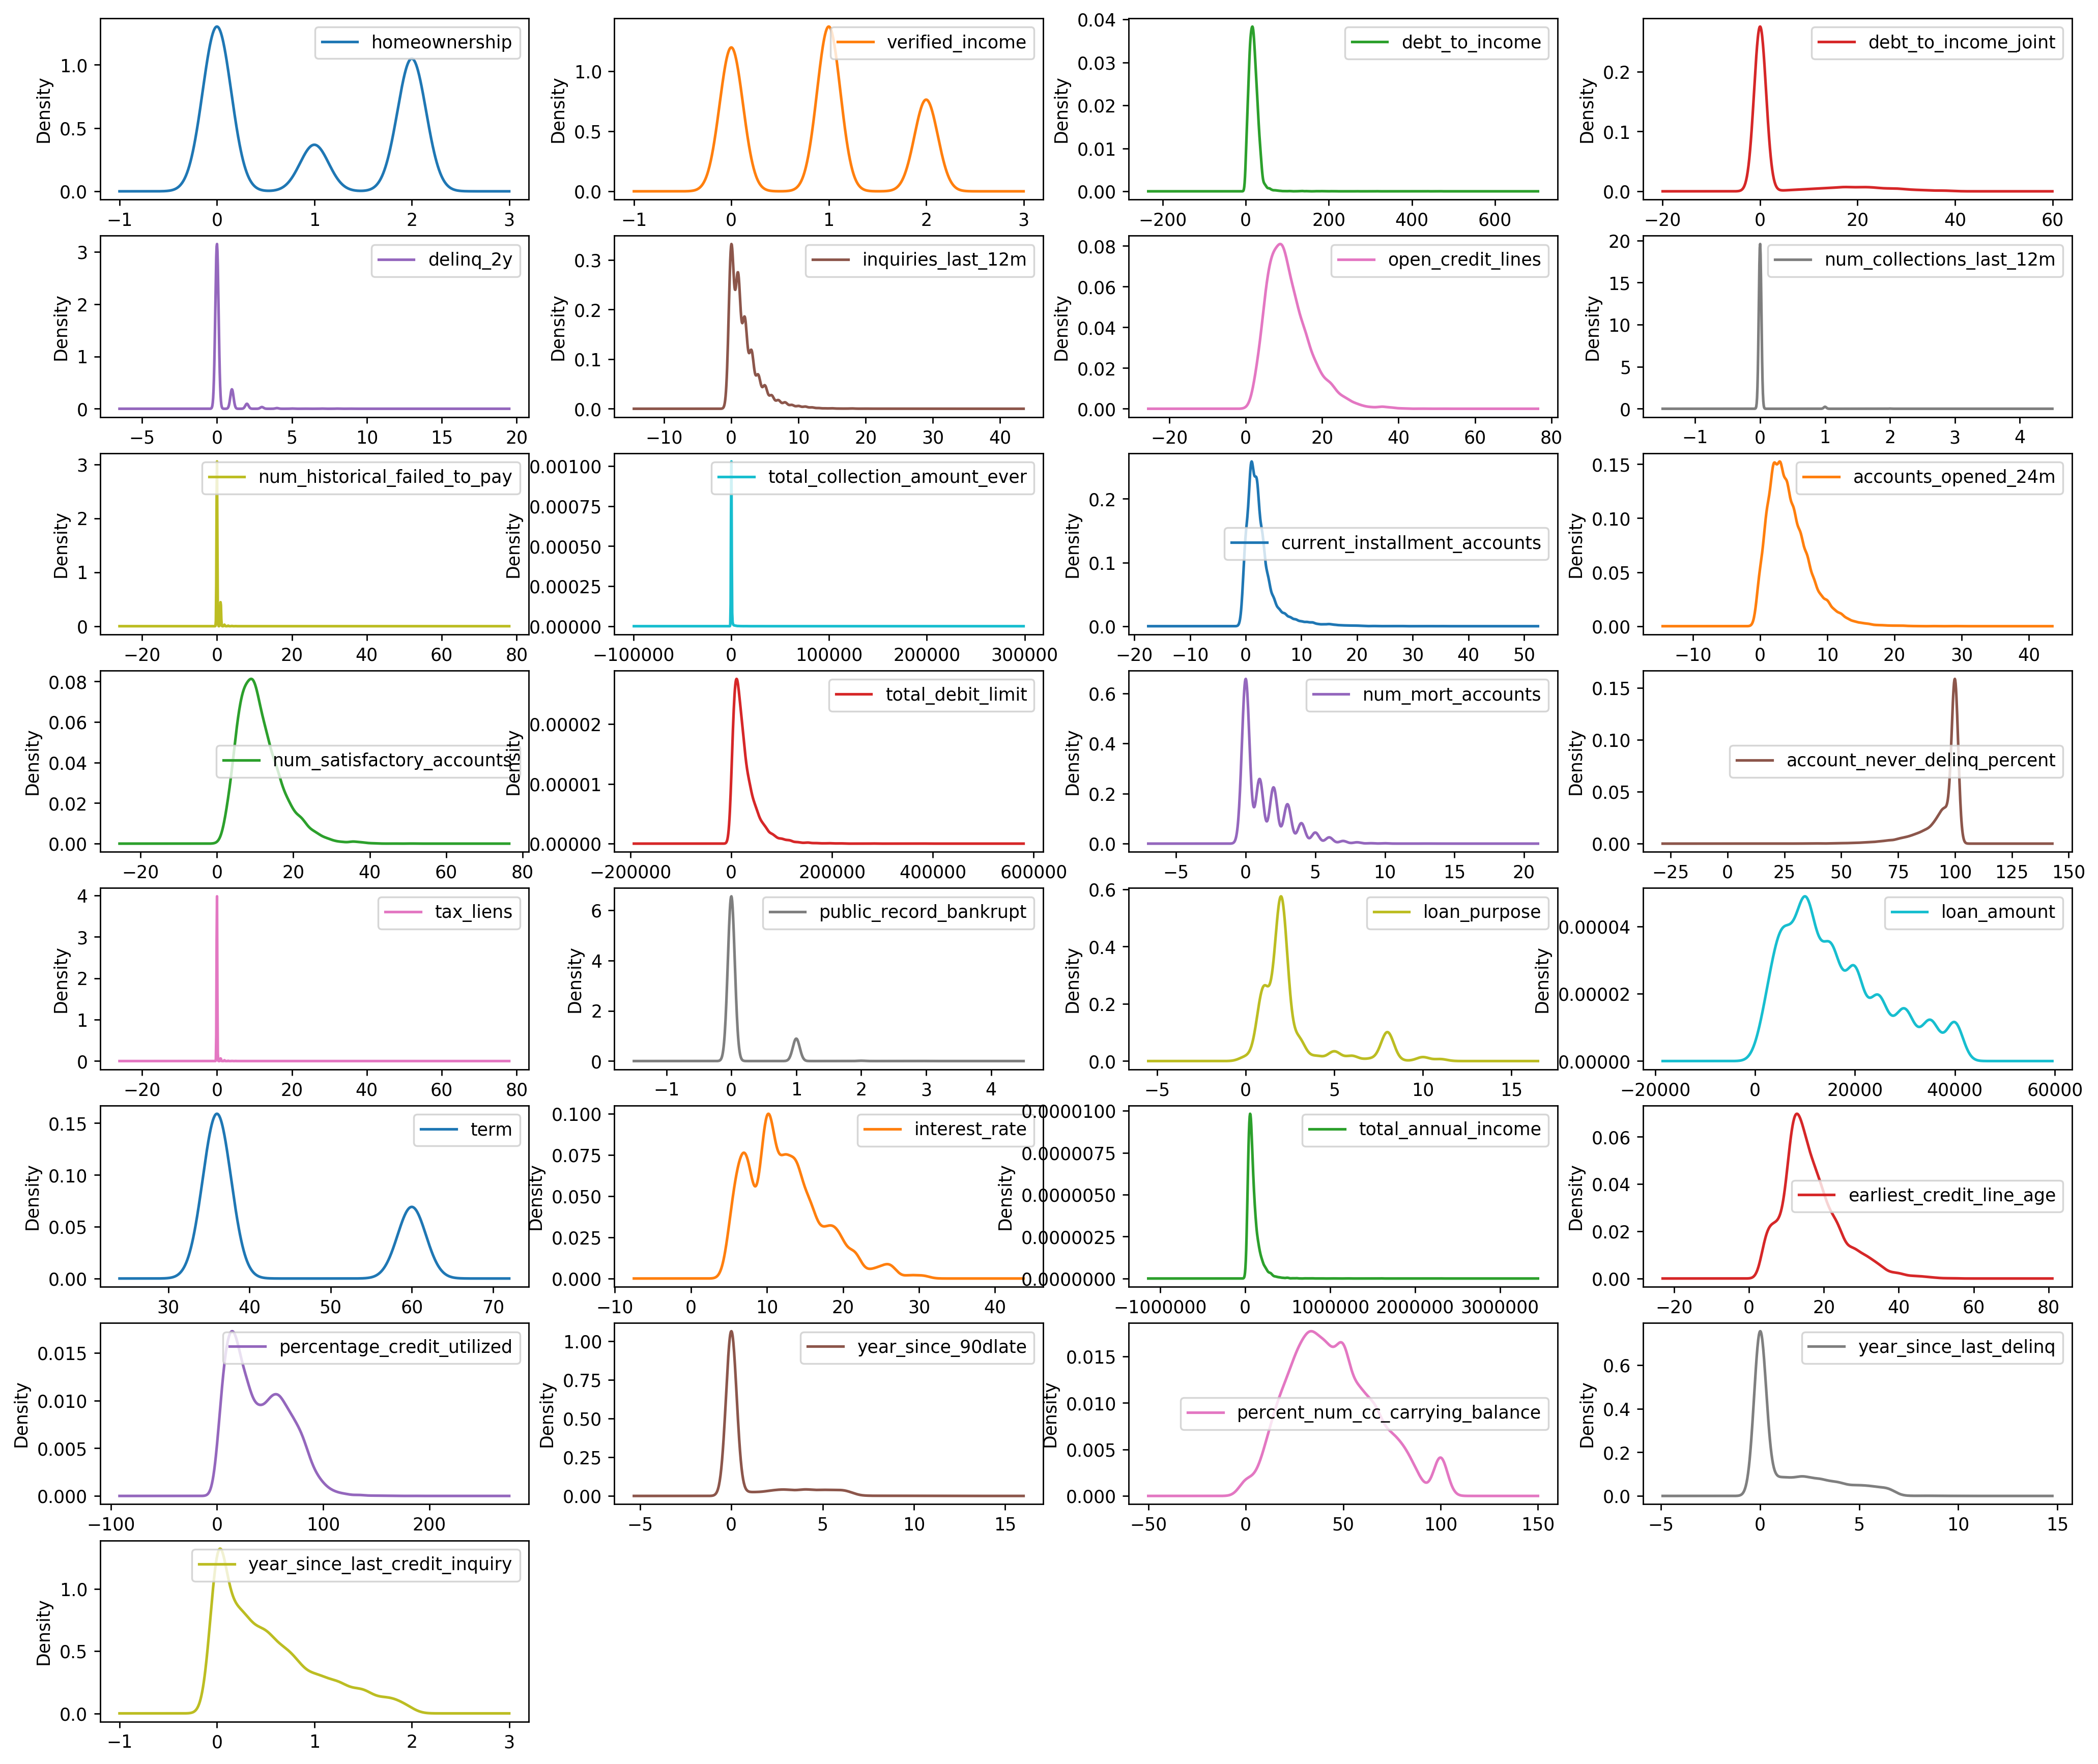

In [19]:
## density plots are effective against histogram when it comes to visualizing the data distribution
print("  Density plot")
dataset.plot(kind='density', subplots=True, layout=(9,4), sharex=False, figsize=(20,20))
pyplot.show()

  Box and whisker plot


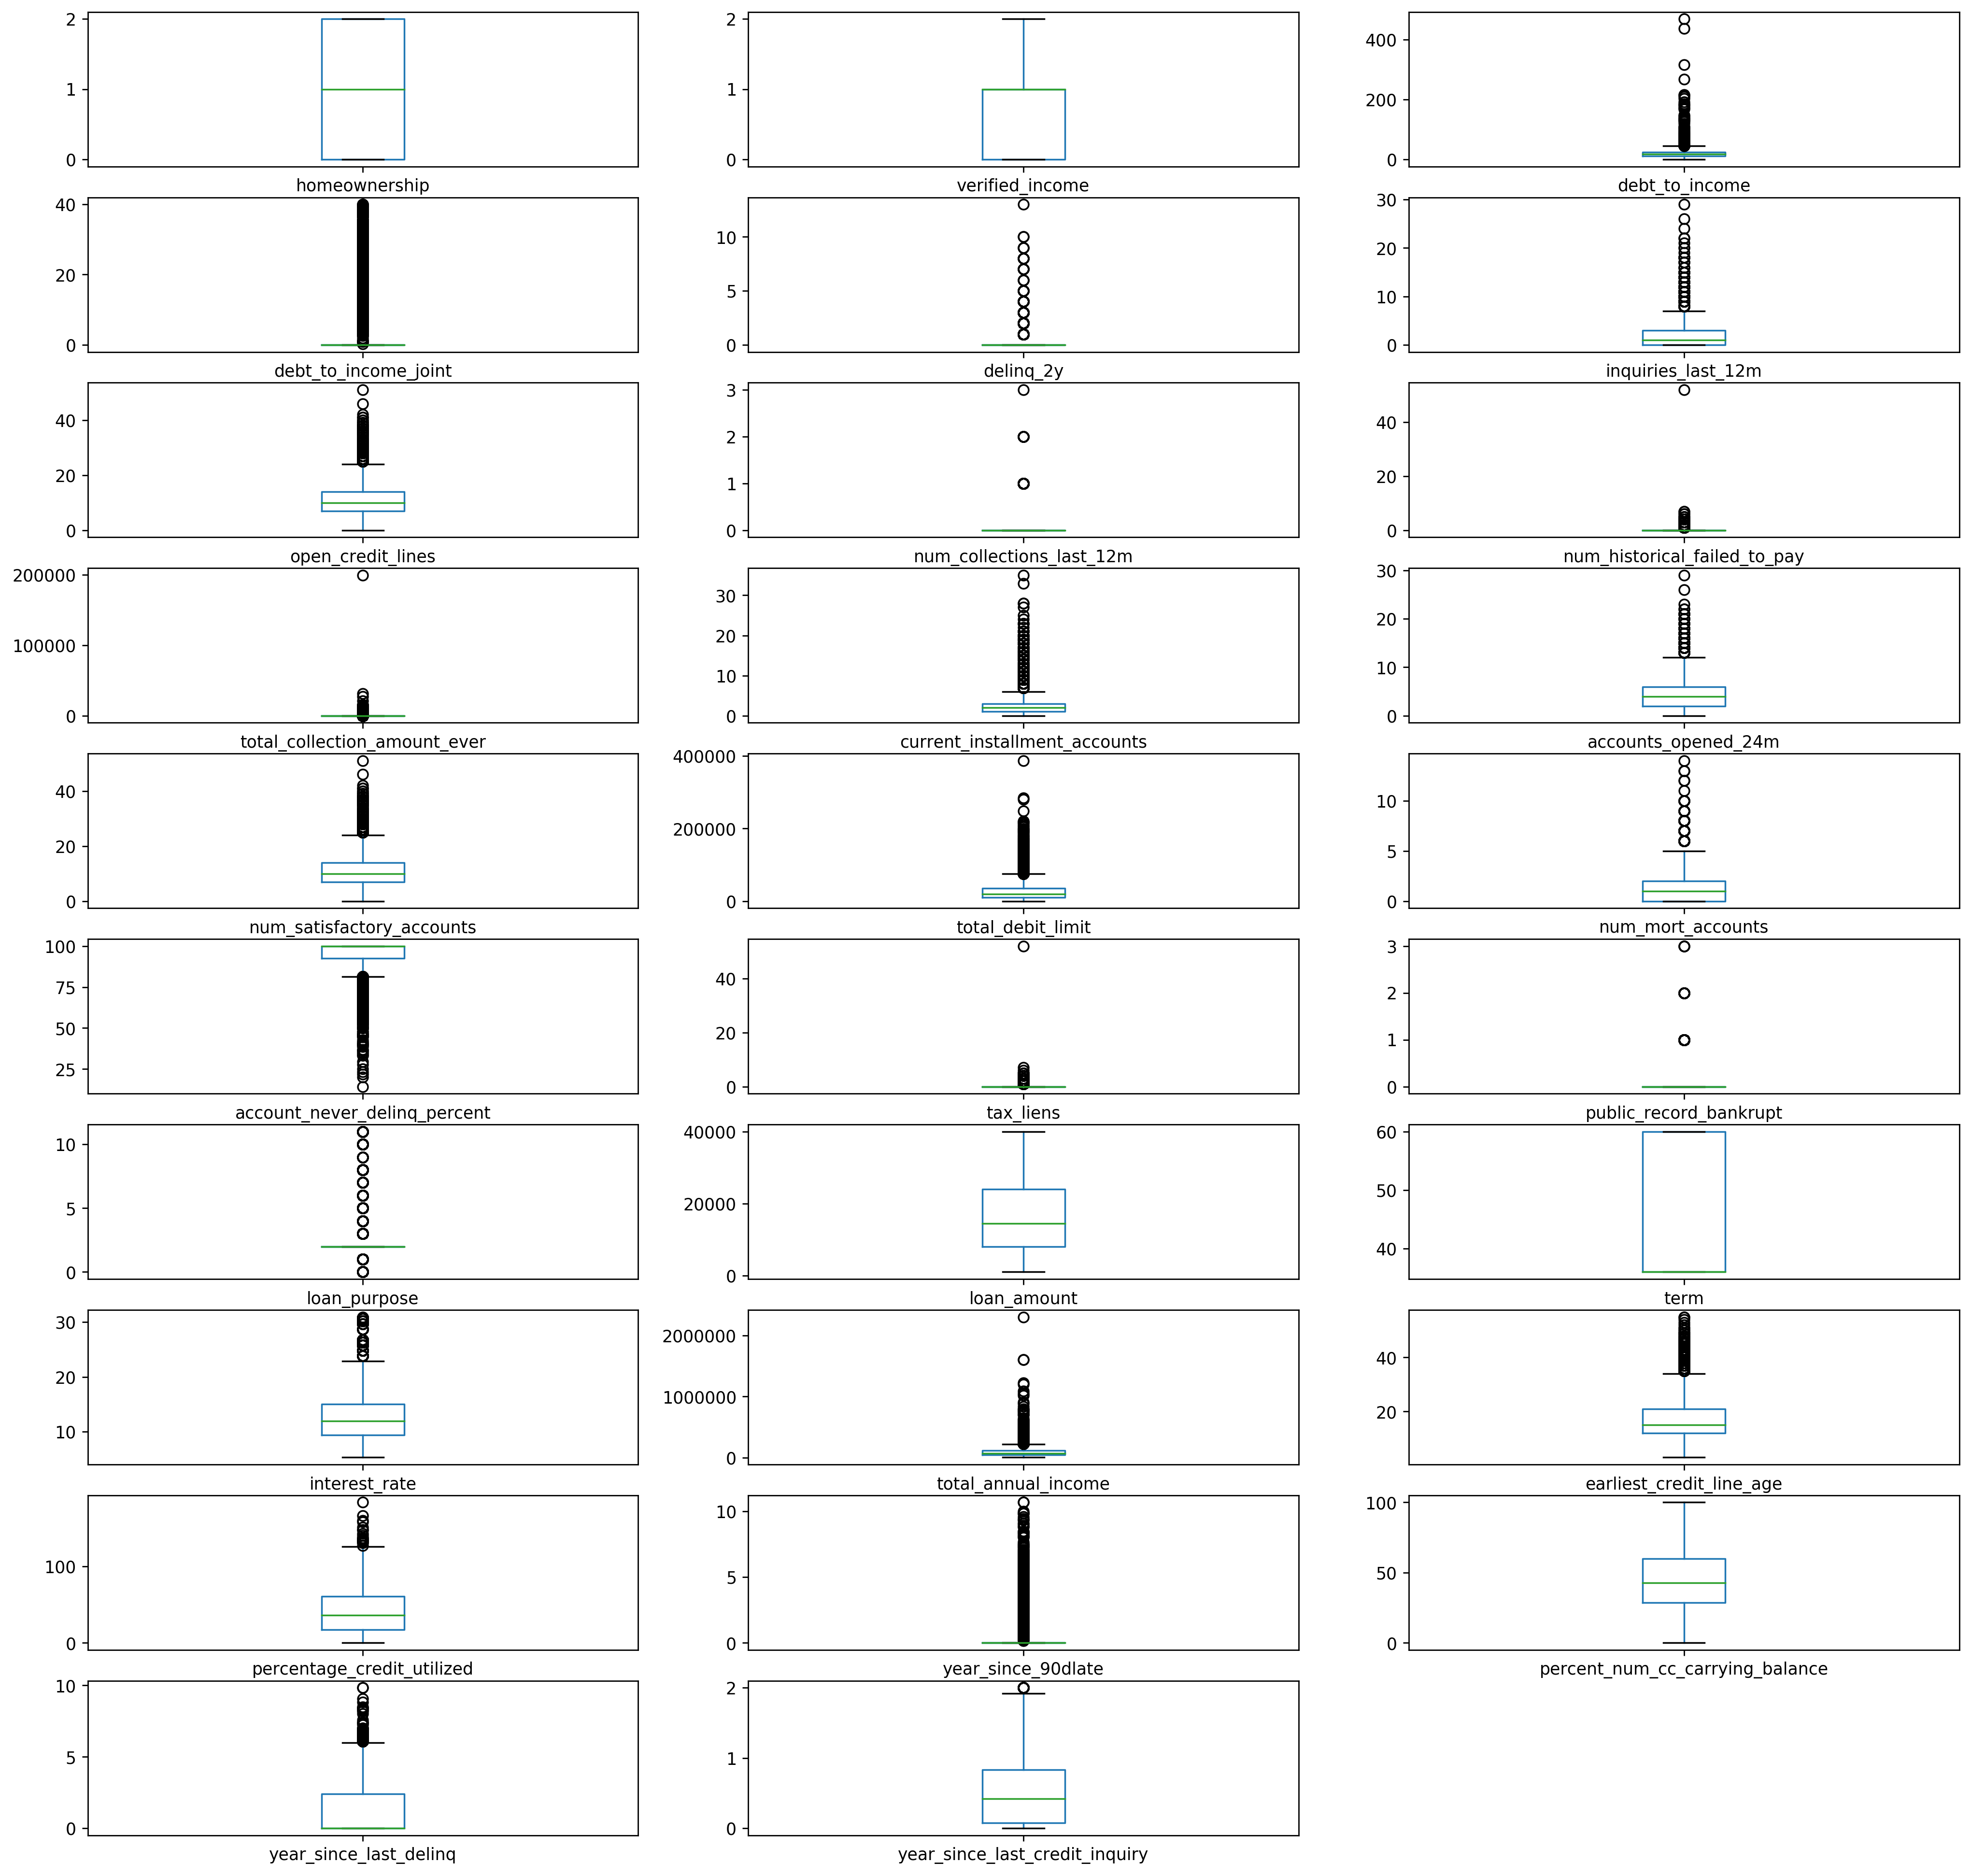

In [20]:
print("  Box and whisker plot")
dataset.plot(kind = 'box', subplots = 'true', layout = (10,3))
plt.rcParams['figure.figsize']=[20,20]
plt.rcParams['figure.dpi']= 250
plt.show()

In [21]:
## dropping the highly correlated column
dataset.drop(['num_satisfactory_accounts'],axis=1, inplace=True)

In [22]:
dataset_X = dataset.drop(['interest_rate'], axis=1)
dataset_Y = dataset['interest_rate']

In [25]:
dataset_std = StandardScaler().fit_transform(dataset)
pca = PCA(n_components = 25)
pcs = pca.fit_transform(dataset_std)
print('the explained variance captured by dataset:',np.cumsum(pca.explained_variance_ratio_))

the explained variance captured by dataset: [0.10902508 0.18878943 0.26773636 0.33928579 0.40197401 0.45619048
 0.50101678 0.54344547 0.58358572 0.6205607  0.65684396 0.6924088
 0.7265881  0.75881478 0.79026878 0.82011815 0.8480109  0.87110845
 0.89189089 0.9083333  0.92421301 0.93978626 0.95412263 0.96724501
 0.98035489]


In [27]:
columns = []
for i in range(25):
     columns.append(i+1)
df = pd.DataFrame(data=pcs, columns=columns)
df['ROI'] = dataset['interest_rate']
df.head()

1         2         3         4         5         6         7  \
0  0.674424  1.931762  0.438492 -0.682014  0.823774 -1.870873 -1.018128   
1 -0.811495 -0.595153  0.739046  2.360534 -1.825887 -0.545638  0.323601   
2 -1.764159  1.696450  1.151768 -0.508283 -1.630450 -1.429719  0.422013   
3 -2.202997 -1.852907 -0.475481  2.078874  0.556598  1.065965 -0.897710   
4  0.542260 -0.684653  3.148243 -2.304930  1.311049  0.034270  2.466293   

          8         9        10  ...        17        18        19        20  \
0 -0.473623  0.837657 -0.188163  ...  0.142784 -0.186108  1.175547 -1.209892   
1 -0.170547 -1.182476 -2.178778  ... -1.218316  0.018986 -1.510285  0.160605   
2 -0.668450  0.904026  0.111449  ... -1.814939 -0.620068 -0.032551  0.351706   
3  0.057125  0.001255  1.236487  ... -0.112529  0.236907  0.655038 -0.756812   
4 -1.480834  1.531613  0.791855  ... -0.538324  0.246030  0.407542 -0.832191   

         21        22        23        24        25    ROI  
0  0.024761 -0.004798  0.542992  0.576840  0.505174  14.07  
1 -0.387388 -0.681710 -0.316159 -0.399979 -0.281028  12.61  
2 -0.265440 -0.861980 -0.061117  0.560614 -0.118829  17.09  
3  0.182953 -0.577585 -0.270740 -0.893427  0.220529   6.72  
4  0.821651 -0.259220 -0.398103 -1.037130  0.138252  14.07  

[5 rows x 26 columns]

In [28]:
df_X = df.drop(['ROI'], axis=1).values
df_Y = df['ROI'].values

In [29]:
df_X.shape

(10000, 25)

In [30]:
df_Y.shape

(10000,)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = 100 * (errors / y_test)
# Calculate and display accuracy. i tried to calculate overall how much accurate is my model its not literal accuracy measure
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 1.54 degrees.
Accuracy: 85.67 %.


In [32]:
##the r2 is measure of correlation between two variables
## the result 0.84 shows that there is a good relationship, and we can use polynomial regression in future predictions.
R_square = sm.r2_score(y_test,predictions)

In [33]:
R_square

0.8464272143138855

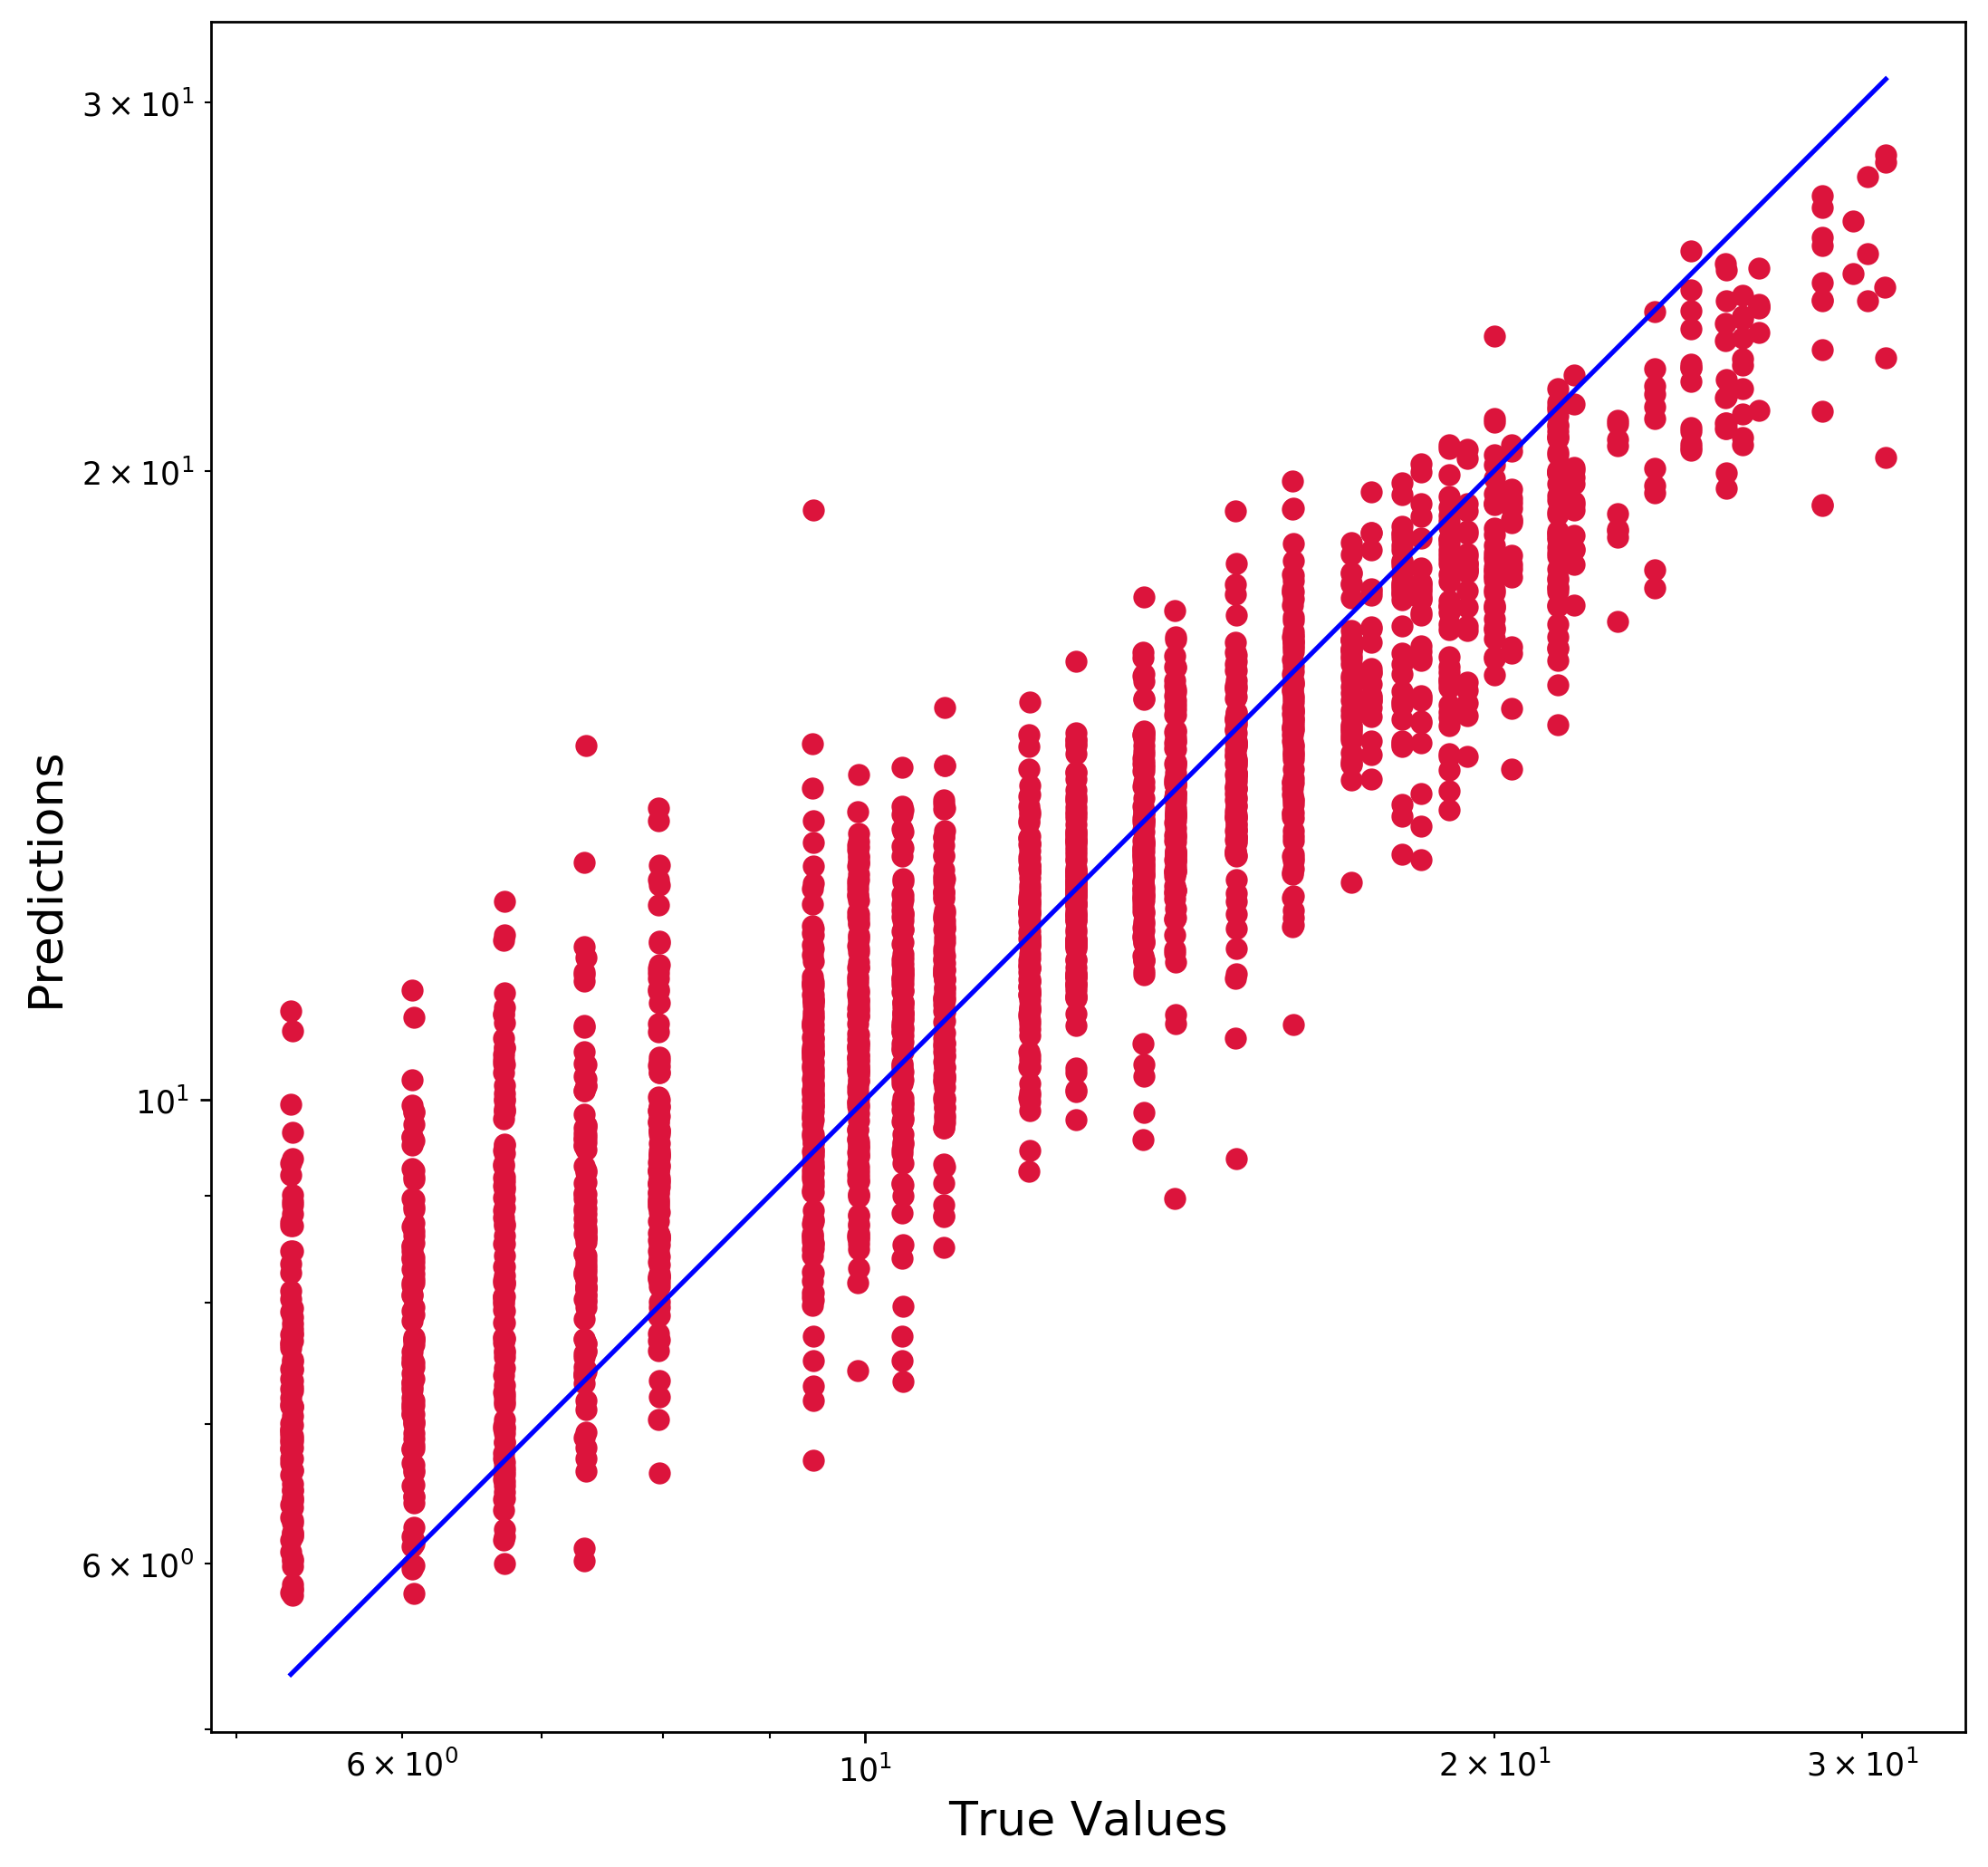

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()